In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


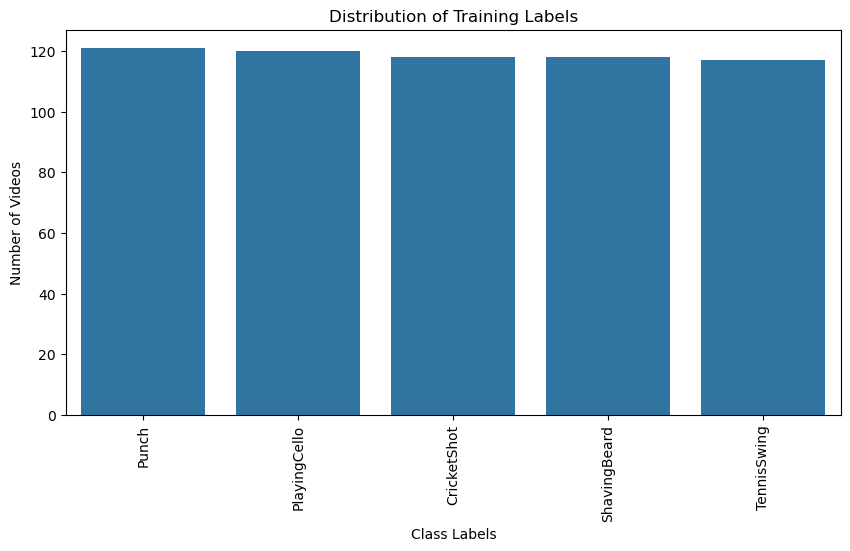

Number of classes: 5


In [5]:
# Define the paths to the directories containing the training and testing videos
train_videos_path = 'Summer-Research-Institute/week7/UCF101Dataset/train'
test_videos_path = 'Summer-Research-Institute/week7/UCF101Dataset/test'

# Load the training and testing labels from CSV files
train_labels = pd.read_csv('Summer-Research-Institute/week7/UCF101Dataset/train.csv')
test_labels = pd.read_csv('Summer-Research-Institute/week7/UCF101Dataset/test.csv')

# Visualize the distribution of classes in the training labels
# This code creates a bar plot showing the number of videos in each class
class_counts = train_labels['tag'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Training Labels')
plt.xlabel('Class Labels')
plt.ylabel('Number of Videos')
plt.xticks(rotation=90)
plt.show()

# Calculate the number of unique classes in the training labels
num_classes = train_labels['tag'].nunique()
print(f'Number of classes: {num_classes}')


In [6]:
def extract_frames(video_path, num_frames=16):
    """
    Extract frames from a video file.

    Args:
    - video_path (str): Path to the video file.
    - num_frames (int): Number of frames to extract (default is 16).

    Returns:
    - frames (np.array): Array of extracted frames.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the interval at which frames will be extracted
    frame_interval = max(total_frames // num_frames, 1)
    
    # Iterate through the frames and extract them
    for i in range(num_frames):
        # Set the frame position to the current frame index
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)
        
        # Read the frame
        ret, frame = cap.read()
        
        # Break the loop if the end of the video is reached
        if not ret:
            break
        
        # Resize the frame to 112x112 pixels
        frame = cv2.resize(frame, (112, 112))
        
        # Append the frame to the frames list
        frames.append(frame)
    
    # Release the video capture object
    cap.release()
    
    # Fill any missing frames with blank (zero) frames
    while len(frames) < num_frames:
        frames.append(np.zeros((112, 112, 3), np.uint8))
    
    # Convert the frames list to a NumPy array
    return np.array(frames)


In [7]:
def load_data(labels, video_dir, num_classes, num_frames=16):
    """
    Load and preprocess video data for training or testing.

    Args:
    - labels (pd.DataFrame): DataFrame containing video labels.
    - video_dir (str): Directory containing video files.
    - num_classes (int): Number of classes in the dataset.
    - num_frames (int): Number of frames to extract per video (default is 16).

    Returns:
    - X (np.array): Array of video frames.
    - y (np.array): Array of one-hot encoded labels.
    """
    X = []
    y = []
    
    # Iterate through each row in the labels DataFrame
    for idx, row in tqdm(labels.iterrows(), total=labels.shape[0]):
        # Construct the path to the video file
        video_path = os.path.join(video_dir, row['video_name'])
        
        # Extract frames from the video
        frames = extract_frames(video_path, num_frames)
        
        # Check if the correct number of frames were extracted
        if len(frames) == num_frames:
            X.append(frames)
            y.append(row['tag'])
    
    # Convert the lists to NumPy arrays
    X = np.array(X)
    
    # Convert the labels to one-hot encoded format
    y = to_categorical(pd.factorize(y)[0], num_classes)
    
    return X, y

# Load and preprocess the training and testing data
X_train, y_train = load_data(train_labels, train_videos_path, num_classes)
X_test, y_test = load_data(test_labels, test_videos_path, num_classes)


100%|██████████| 594/594 [00:20<00:00, 29.43it/s]
/var/folders/f9/hp5r6d1j58s_ckdj_flq1wfh0000gn/T/ipykernel_8654/513613156.py:35: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  y = to_categorical(pd.factorize(y)[0], num_classes)
100%|██████████| 224/224 [00:06<00:00, 33.28it/s]


In [8]:
# Split the training data into training and validation sets
# X_train and y_train are the input features (video frames) and labels (one-hot encoded) for the training data, respectively
# test_size=0.2 specifies that 20% of the training data should be used for validation, while the remaining 80% is used for actual training
# random_state=42 sets the random seed for reproducibility, ensuring that the split is the same each time the code is run
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# After this line of code, you will have:
# X_train: Training set features (video frames)
# X_val: Validation set features (video frames)
# y_train: Training set labels (one-hot encoded)
# y_val: Validation set labels (one-hot encoded)
# These datasets can then be used for training and evaluating your 3D CNN model


In [9]:
def create_advanced_3dcnn_model(input_shape, num_classes):
    """
    Create an advanced 3D CNN model for video classification.

    Args:
    - input_shape (tuple): Shape of input frames (e.g., (16, 112, 112, 3) for 16 frames of size 112x112 pixels and 3 channels).
    - num_classes (int): Number of classes in the classification task.

    Returns:
    - model (Sequential): Compiled 3D CNN model.
    """
    model = Sequential()
    
    # 3D convolutional layer with 64 filters, kernel size of (3, 3, 3), and ReLU activation
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    # 3D max pooling layer with pool size of (2, 2, 2)
    model.add(MaxPooling3D((2, 2, 2)))
    # Batch normalization layer
    model.add(BatchNormalization())

    # Another 3D convolutional layer with 128 filters, kernel size of (3, 3, 3), and ReLU activation
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    # Another 3D max pooling layer with pool size of (2, 2, 2)
    model.add(MaxPooling3D((2, 2, 2)))
    # Another batch normalization layer
    model.add(BatchNormalization())

    # Another 3D convolutional layer with 256 filters, kernel size of (3, 3, 3), and ReLU activation
    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
    # Another 3D max pooling layer with pool size of (2, 2, 2)
    model.add(MaxPooling3D((2, 2, 2)))
    # Another batch normalization layer
    model.add(BatchNormalization())

    # Flatten layer to flatten the output of the convolutional layers
    model.add(Flatten())
    # Fully connected (dense) layer with 512 units and ReLU activation
    model.add(Dense(512, activation='relu'))
    # Dropout layer with dropout rate of 0.5
    model.add(Dropout(0.5))
    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define the shape of input frames and create the advanced 3D CNN model
input_shape = (16, 112, 112, 3)
model = create_advanced_3dcnn_model(input_shape, num_classes)


/opt/anaconda3/envs/keras3dcnn/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-05 01:04:32.040832: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-09-05 01:04:32.040879: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-09-05 01:04:32.040894: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-09-05 01:04:32.041116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-05 01:04:32.041133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

In [10]:
# Train the 3D CNN model
# X_train and y_train are the training set features (video frames) and labels (one-hot encoded), respectively
# X_val and y_val are the validation set features (video frames) and labels (one-hot encoded), respectively
# epochs=10 specifies the number of training epochs (iterations over the entire dataset)
# batch_size=8 specifies the number of samples per gradient update
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8)


Epoch 1/10


2024-09-05 01:05:00.471399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-09-05 01:05:00.476936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6036 - loss: 25.3819

2024-09-05 01:09:25.574043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


60/60 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.6055 - loss: 25.3302 - val_accuracy: 0.4706 - val_loss: 425.3773
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - accuracy: 0.8548 - loss: 14.4419 - val_accuracy: 0.4202 - val_loss: 378.8347
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.9028 - loss: 10.8090 - val_accuracy: 0.6050 - val_loss: 121.1481
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 268s 4s/step - accuracy: 0.9180 - loss: 8.3968 - val_accuracy: 0.8151 - val_loss: 25.1320
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.9159 - loss: 7.4426 - val_accuracy: 0.8487 - val_loss: 30.7338
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.9806 - loss: 2.1084 - val_accuracy: 0.6218 - val_loss: 71.3718
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 268s 4s/step - accuracy: 0.9745 - loss: 1.4990 - val_accuracy: 0.9244 - val_loss: 10.7357
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 281s 5s/step - accuracy: 0.9564 - loss: 4.2686 - val_accuracy: 0.6555 -

In [12]:
# Evaluate the trained model on the test set
# X_test and y_test are the test set features (video frames) and labels (one-hot encoded), respectively
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print(f'Test Accuracy: {accuracy:.2f}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4442 - loss: 174.1798
Test Accuracy: 0.51


In [13]:
# Get predictions from the model
# X_test is the test set features (video frames)
# y_pred contains the predicted probabilities for each class for each sample in X_test
y_pred = model.predict(X_test)

# Convert the predicted probabilities to class labels
# y_pred_classes contains the predicted class labels (indices) for each sample in X_test
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels to class labels
# y_true_classes contains the true class labels (indices) for each sample in X_test
y_true_classes = np.argmax(y_test, axis=1)


2024-09-05 01:51:07.848350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate the confusion matrix
# y_true_classes are the true class labels for each sample in the test set
# y_pred_classes are the predicted class labels for each sample in the test set
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


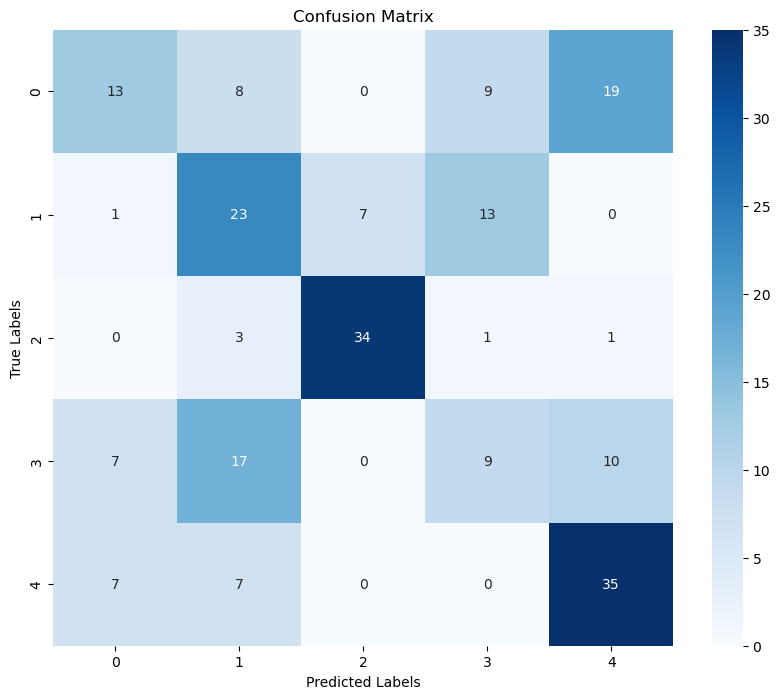

In [15]:
# Plot the confusion matrix
# conf_matrix is the confusion matrix computed using the true and predicted class labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [16]:
# Print the classification report
# y_true_classes are the true class labels for each sample in the test set
# y_pred_classes are the predicted class labels for each sample in the test set
# target_names are the unique class labels used for the classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=train_labels['tag'].unique())
print(class_report)


              precision    recall  f1-score   support

 CricketShot       0.46      0.27      0.34        49
PlayingCello       0.40      0.52      0.45        44
       Punch       0.83      0.87      0.85        39
ShavingBeard       0.28      0.21      0.24        43
 TennisSwing       0.54      0.71      0.61        49

    accuracy                           0.51       224
   macro avg       0.50      0.52      0.50       224
weighted avg       0.50      0.51      0.49       224



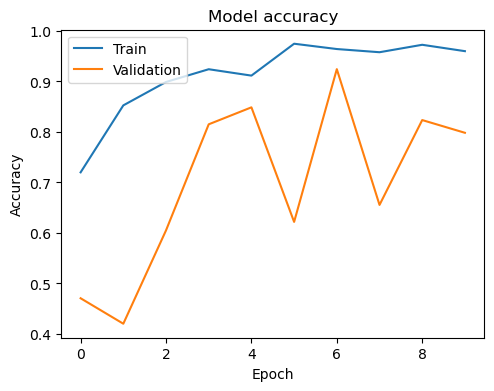

In [17]:
# Plot the training history
# history is the training history object returned by model.fit
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


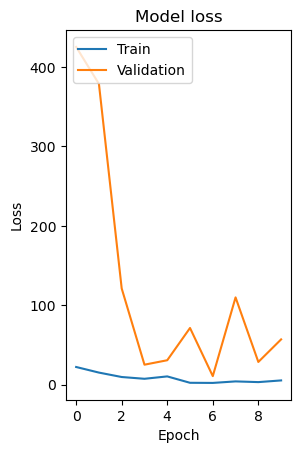

In [18]:
# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
